# `AA Workshop 06` - Polynomial Regression & Generalization
This notebook focuses on polynomial modeling and the issue of generalization. These are, in fact, two separate and distinct issues in machine learning, but they arise very naturally in contection with each other, which is why we choose to introduce them at the same time here. Nonetheless, it is important to keep in mind that they are different topics, and that generalization issues can arise for any type of regression or classification (linear or "non-linear").

We will go through the following:
- "non-linear" modeling using polynomial regression
- overfitting & cross-validation
- L1 & L2 regularization
- other regression algorithms

---

## Recap: Predicting peak electrical power

We will again work with our electrical power example from last week, which we retrieved from PJM via the following link [here](https://dataminer2.pjm.com/feed/hrl_load_metered/definition). The files we are loading are the raw files we downloaded from this source. The final input data for our code is `Pittsburgh_load_data.csv` (in the `data` folder in the project root directory).

**Recall from last week's workshop**: We fitted a linear model to the summer period of our electricity data. To do so, we used `scikit-learn` and obtained the following result:

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline

[0.08385936] -0.08024740699315025


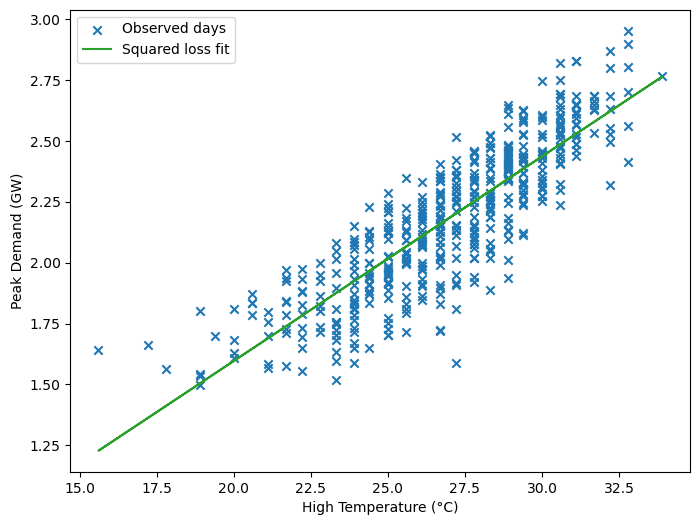

In [2]:
# load data
df = pd.read_csv("../data/Pittsburgh_load_data.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df["Month"] = df["Date"].apply(lambda x: x.month)

# limit to summer months
df_summer = df[(df["Month"] > 5) & (df["Month"] < 9)]

# define features
xp = df_summer["High_temp"].values.reshape((-1,1)) # remember: if we pass a 1-feature array we need to re-shape it!
yp = df_summer["MAX"]

# initialize model
lin_mod = LinearRegression()

# train model
lin_mod.fit(xp, yp)

# make predictions using model
model_pred = lin_mod.predict(xp)

# plot results
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(xp, model_pred, c='C2')
plt.legend(['Observed days', 'Squared loss fit'])
print(lin_mod.coef_, lin_mod.intercept_)
plt.show()

---

## "Non-linear" modeling
The relationship between high temperature (`xp`)and electrical peak demand (`yp`) is adequately modelled by a linear function during the summer months, when (at least in Pittsburgh) electricity consumption is dominated by air conditioners (so that with higher temperatures comes higher consumption). However, this is clearly not the case for the entire year. Indeed, if our previous linear model is believed to be applicable in general, then with lower temperatures we would continue to have lower and lower consumption (until, at some point, we’d start generating electricity - remember also the negative intercept of our linear regression model for the summer months). Naturally, this is not the case, and if we instead consider the entire year, a different picture emerges.

In [3]:
# re-define xp and yp to consider the entire dataframe, not just df_summer
xp = df["High_temp"]
yp = df["MAX"]

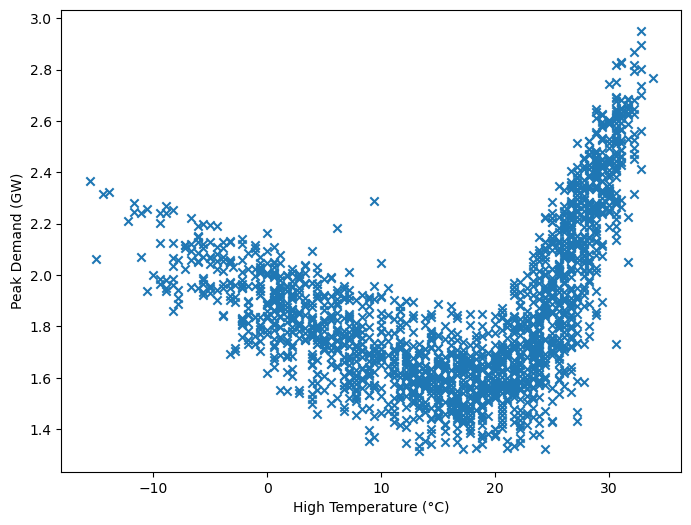

In [4]:
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x")
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

The plotted data looks more like we would expect. Although peak demand increases sharply with temperature after a high temperature of 22 degrees or so (precisely the range when air conditioning usually starts), below this the demand actually starts to increase with lower temperature – though not with as steep a slope, due to the fact that, for example, most heating in Pittsburgh is done with gas rather than with electricity, and other loads that increase with lower temperatures tend to be smaller in magnitude than air conditioning units.

### Linear regression
If we were to fit a linear model to this data, it would look like the following:

The R^2 of linear regression is:  0.09387669129560838


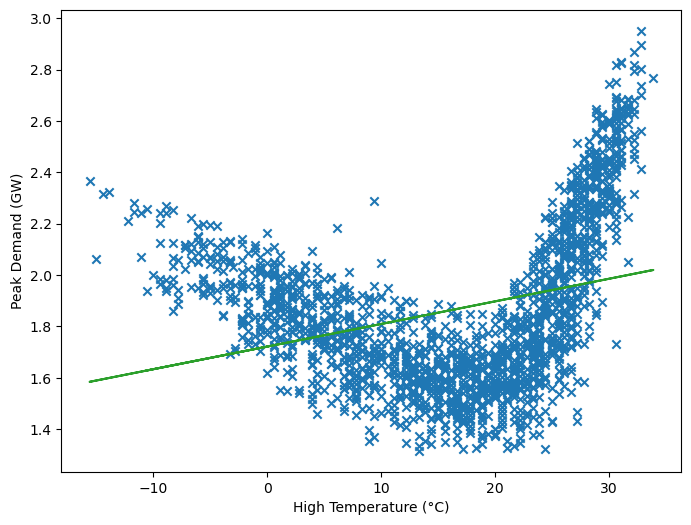

In [5]:
# initialize, fit and predict
lr = LinearRegression()
lr.fit(xp.values.reshape(-1,1), yp)
model_pred_p = lr.predict(xp.values.reshape(-1,1))

# plot figure
plt.figure(figsize = (8,6))
plt.scatter(xp, yp, marker="x" )
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.plot(xp, model_pred_p, c='C2')
print ('The R^2 of linear regression is: ', r2_score(y_true = yp, y_pred = model_pred_p))

### Polynomial regression
To capture data of this type, we clearly want some way of expressing nonlinear relationships in the data.  Fortunately, this is possible without actually leaving the domain of so-called "linear regression".  The trick we are going to use is a simple one: rather than have features $x^{(i)}$ which only include the "raw" inputs such as temperature (plus other raw inputs such as weekday indicators that we saw previously), we are going to build features that include _nonlinear_ functions of the underlying inputs. For example, we could choose the following features
\begin{equation}
x^{(i)} = \left [ \begin{array}{c} (\mathrm{HighTemperature}^{(i)})^2 \\
\mathrm{HighTemperature}^{(i)} \\ 1 \end{array} \right ]
\end{equation}
which also include a quadratic function of the high temperature variable. If we choose this representation, then our linear hypothesis function $h_\theta(x) = \theta^Tx$ is now given by
\begin{equation}
h_\theta(x) = \theta_1 (\mathrm{HighTemperature}^{(i)})^2 + \theta_2 \mathrm{HighTemperature}^{(i)} + \theta_3
\end{equation}
which is a _quadratic_ function of the high temperature.  Importantly, however, the hypothesis function is still a linear function of the parameters, and so the exact same solution methods work as before (including the exact solution), just by passing a different feature matrix.

Let us first do this by hand. We define a simple function entitled `plot_regression_poly` that takes features, target and the degree of the polynomial as input.

In this setting we're actually going to standardize features to the range $[-1,+1]$ even with the least-squares analytical solution for numerical reasons.  High polynomials get very large very quickly, and if we aren't careful it's easy to overload the range of double precision floating point values.

To standardize to the range $[-1,+1]$ we use the following formula: 
\begin{equation}
2*\frac{x - min(x)}{max(x) - min(x)}-1
\end{equation}

In [6]:
# x is the input variable
# y is the output variable
# d is degree of polynomial regression

def plot_regression_poly(x, y, d):
    
    # create polynomial features
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x)-1  # standardize to range [-1,1]
    X = np.array([xs**i for i in range(d,-1,-1)]).T # start at highest polynomial degree (d) and go backwards until 0 in steps of 1
    
    # implement polynomial regression using least squares (we use the normal equations as derived in the lecture)
    theta = np.linalg.solve(X.T @ X, X.T @ y)
    
    # create scaled test dataset
    xt0 = np.linspace(min_x-1, max_x+1, 400) # generate equally spaced x values in the x range
    xt = 2 * (xt0 - min_x)/(max_x - min_x) -1 # standardize to range [-1,1]
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T # generate polynomial features
    yt = Xt @ theta # generate predicted y values
    
    # plot results
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:7]) # print first 7 thetas

Quadratic regression for peak demand data:

[ 1.19800453 -0.19250338  1.58898561]


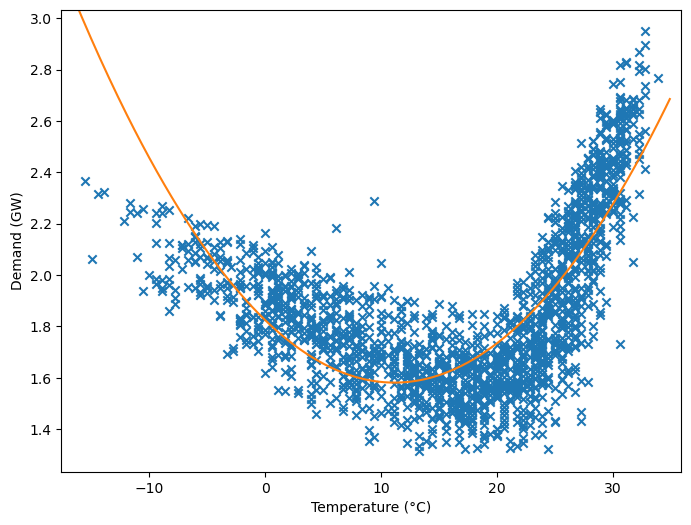

In [7]:
plot_regression_poly(x = xp, y=yp, d = 2)

This looks better, but a quadratic function is symmetric around its minimum point, and the data we're trying to fit is definitely not symmetric. Thus, we may want a cubic function.

[ 1.11163335  0.81686774 -0.59852881  1.64885721]


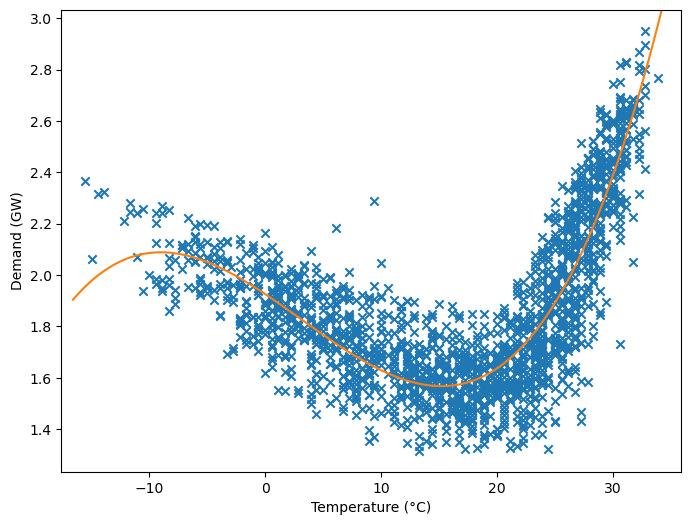

In [8]:
# plot of Peak demand vs. High temperature with cubic polynomial regression
plot_regression_poly(x = xp, y=yp, d = 3)

This does not look bad. Let's keep going:

[-0.75717174  0.6052924   1.66483831  0.42155216 -0.65742564  1.67658979]


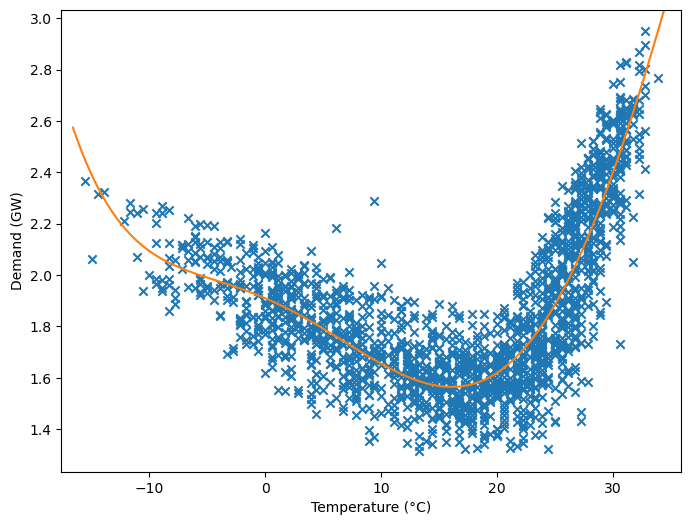

In [9]:
# try some other values for d --> What seems to be a good one?
plot_regression_poly(x = xp, y=yp, d = 5)

How about a 100-degree polynomial? Is this something we want? Also, what do you think about the value of the coefficients?

[ -416446.58345106  1678986.27406802  -613206.60569437   845062.5420469
   -55497.84705352 -1516712.81546627   740868.90757933]


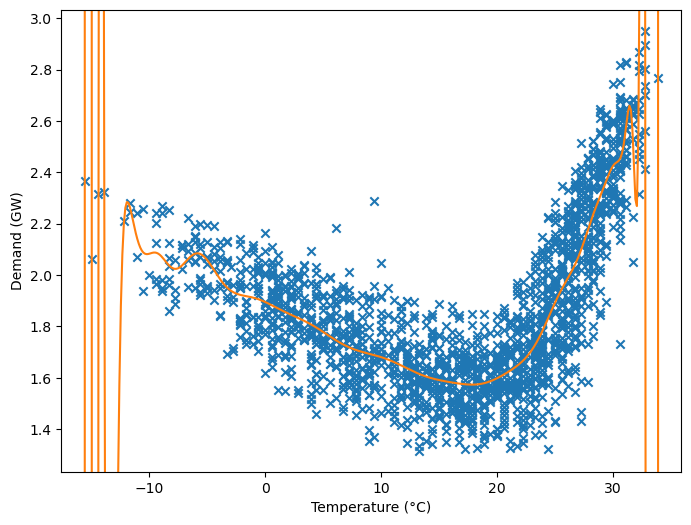

In [10]:
plot_regression_poly(x = xp, y=yp, d = 100)

Something very bad has happened at this point. Especially at the tail ends of the data, where the data points are spaced less closely, we start to get very odd patterns for the data. But the important point is that this is actually a very good fit to the data from a least-squares perspective. As you can see from the figure, the lines pass exactly through many of the data point (most obvious on the left hand side of the plot), whereas for the "better" fits we had above, our function didn't pass exactly through those points, so actually suffered more loss. But there is an obvious way in which the degree 100 polynomial fit, despite having lower loss, is actually a worse approximation to the underlying data. This brings us to the second topic of these notes, which is the issue of generlization and overfitting.

In the following first one of the useful python libraries has been introduced for regression task then we continue with generlization and overfitting topic.

We will see shortly how we manage these situations, but let us first implement the above example using `scikit learn`. Essentially, all we need to do is to pre-process our feature vector and create polynomial features. To do so, we use a built-in module called `PolynomialFeatures`.

### Using scikit-learn library for fitting a polynomial regression

In [11]:
from sklearn.preprocessing import PolynomialFeatures

Let us first consider a toy example to understand how this module works

In [12]:
Q = np.array([[2,3,4], [5,6,7]]).T # let's assume we have two features

# initialize PolynomialFeatures
PF = PolynomialFeatures(degree = 2,interaction_only = False, include_bias = True)
Q_Poly = PF.fit_transform(Q)
print(Q)
print(Q_Poly)

[[2 5]
 [3 6]
 [4 7]]
[[ 1.  2.  5.  4. 10. 25.]
 [ 1.  3.  6.  9. 18. 36.]
 [ 1.  4.  7. 16. 28. 49.]]


In [13]:
Q = np.array([[2,3,4], [5,6,7]])
PF = PolynomialFeatures(degree = 2,interaction_only = False, include_bias = True)
Q_Poly = PF.fit_transform(Q.reshape(-1,1))
print(Q_Poly)

[[ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]
 [ 1.  6. 36.]
 [ 1.  7. 49.]]


**Note**: This will generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]. This is slightly different from what we have done manually above but is a more common way of creating polynomial features.

In [14]:
def plot_regression_poly_scikit(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures(degree = d)
    
    # polynomial transformation
    x_poly = poly_reg.fit_transform(X.values.reshape(-1,1))
    
    # fitting linear regression to polynomial features
    lin_reg_Poly = LinearRegression()
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(), X.max(), 1)
    x_fit_poly = poly_reg.fit_transform(x_fit.reshape(-1,1))
    y_pred = lin_reg_Poly.predict(x_fit_poly)
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="x", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    #print(lin_reg_Poly.coef_)

The R^2 for quadratic curve is:  0.7531939793416651


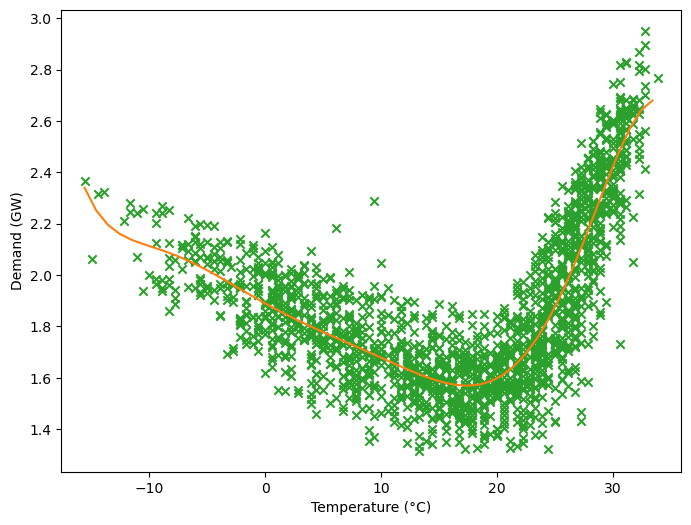

In [15]:
plot_regression_poly_scikit(X = xp, Y = yp, d = 8)

---

## Generalization and overfitting

Recall from our previous discussions that the canonical machine learning problem that we solve with every algorithm is the following
\begin{equation}
\underset{\theta}{minimize} \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)}),y^{(i)} \right)
\end{equation}
i.e., to minimize the sum of losses on the data set. However, in a more fundamental way, this is not really our goal.  We ultimately do not care about achieving low loss specifically on the points that we are feeding into the algorithm: we already _know_ the true output for each of these data points, and if we want to "predict" these points precisely, we could just look up each point in a database (assuming we have some way of referring to the points uniquely).  What we _really_ want from a machine learning algorithm is the ability to predict _new_ data points _of the same type_ as those we trained our model on.  We don't care about knowing what the peak demand _was_ on previous days we have already seen; we care about being able to predict what the peak demand _will be_ tomorrow given the high temperature as input.

**Generalization error** 

This discussion leads us to the notion of _generalization error_.  Informally, the generalization error is just the error (or more generally, the loss) we would experience not on the training data itself, but on new data drawn from the "same distribution" as the training data. _This_ is really the quantity we want to minimize, not the error on the training data itself. Because when we run our machine learning algorithm on new data, all that will matter is its generalization performance.

What the above example illustrated was an instance of _overfitting_, the situation where the training error is low, but the generalization error is high.  This occurs because we are explicitly trying to minimize the loss on the training set, and if the expressiveness of a hypothesis function is small enough, then we can make this loss arbitrarily small, usually by fitting to pecularities in the training data that provide no real benefit when looking at new data.

**Overfitting and model complexity**

In general, we expect something like the following behavior when it comes to overfitting.  We're showing the "cartoon" form here but we will shortly see what this looks like in practice.

![Cartoon illustration of overfitting](overfitting.svg)

When model complexity is low, both training and generalization loss are high (here, model complexity can mean any type of representational power of the model, but since we have covered this so far, you can think of it just as the degree of the polynomial in our feature vector).  As we increase model complexity (i.e. add polynomial degrees), then both training and generalization loss start to decrease with training loss usually slightly lower than generalization loss (due to the simple fact that we explicitly optimize training loss).  As we futher increase model complexity, training loss will continue to only decrease: by adding additional representational power to our model, we will only fit the data better and better, since we are explicitly choosing parameters to minimize this loss.  But at a certain point, generalization loss will start to increase again. Our goal when choosing the "right" model for a particular machine learning problem is to find the model with lowest generalization error, the minimum of the red line above. However, we cannot do so using the training set alone, because performance on the training set (the blue line) gives us no clue about the generalization performance.

### Standard cross validation

The idea of cross validation is simple.  Given the entirety of our training data, we take some fixed percentage, say 70% of the data, and call this our "new" training set.  We then take the remaining data (30% in this case), and call it the _holdout_ or _validation_ set.  The basic idea is that we will use the emprical error or loss on this holdout set as an approximation for the generalization error.  This works because, unlike the training set, we do _not_ choose the parameters of the model based upon the validation set.  This means that there is no way for the parameters to overfit to this data, and thus the validation set provides a reasonable estimate of generalization error even _after_ the parameters have been trained.

Let's see how to generate these training and validation sets.

#### Train-test split by hand

In [16]:
# create an array
X = df["High_temp"]

# create randomly shuffled list of indexes 
np.random.seed(10) # this method is called when RandomState is initialized
perm = np.random.permutation(len(X))

# select first 70% indices of shuffled list as train set
idx_train = perm[:int(len(perm)*0.7)]

# select last 30% indices of shuffled list as holdout set
idx_cv = perm[int(len(perm)*0.7):]

x_train, y_train = df["High_temp"].iloc[idx_train].values, df["MAX"].iloc[idx_train].values
x_cv, y_cv = df["High_temp"].iloc[idx_cv].values, df["MAX"].iloc[idx_cv].values

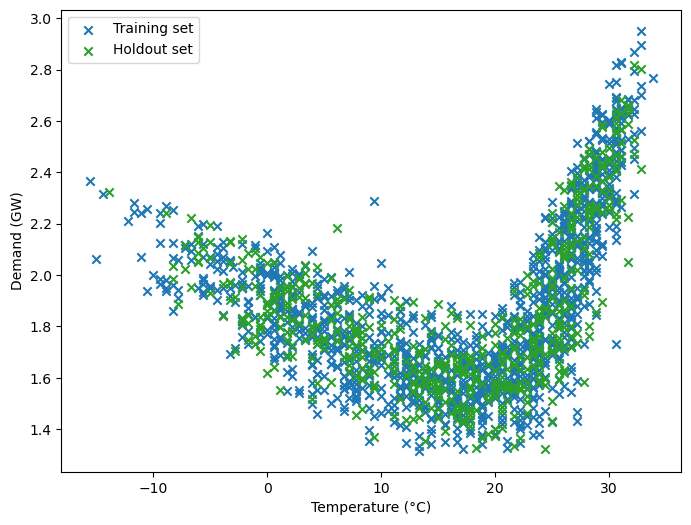

In [17]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_cv, y_cv, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
plt.show()
#plt.savefig('crossvalidation.png', dpi = 300)

Now let’s standardize and generate polynomial features for the training and cross validation sets. The standard procedure here is that we should compute all feature normalization based upon the training set alone, and only afterwards apply this same normalization to the test set. Note that in some cases it is permissable to include cross validation data points (obviously not the labels) into the normalization process (namely if you expect to have similar access to all the “unlabeled” data you will be evaluating the system on prior to training the system), but it’s much more standard to simply use just the training set for everything, including normalization.

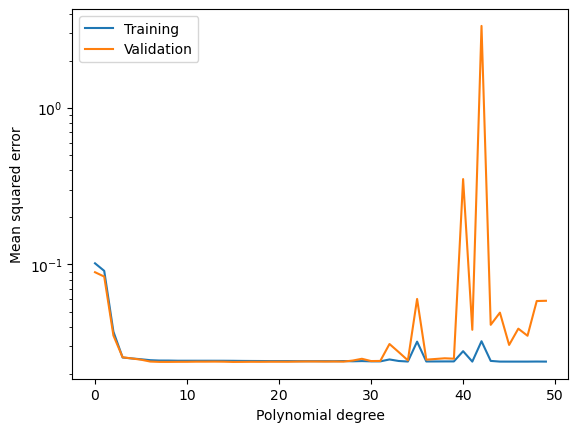

In [18]:
min_x_train, max_x_train = x_train.min(), x_train.max()
x_train = 2*(x_train - min_x_train)/(max_x_train - min_x_train) - 1
x_cv = 2*(x_cv - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T

def ls_poly(x, y, degree):
    X = np.array([x**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X, X.T @ y)  


err_train = []
err_cv = []
for i in range(50):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_cv.append(((poly_feat(x_cv,i) @ theta - y_cv)**2).mean())
plt.semilogy(range(50), err_train, range(50), err_cv)
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.show()

Don't worry about the little increases in training loss at the high end of the figure: these result from numerical instabilities that occur as you have polynomials with very high degrees (simply put, at this range, the numerical accuracy of double precision is not high enough). But the point here is hopefully clear: as model complexity rises, training error decreases, while cross validation error can increase greatly (notice that we are using a log scale for the plot). But it's also worth emphasizing that this is not a monotonic process: again, due to peculiarities in the data, the cross validation loss can jump around significantly. You want to pay more attention to the general trend instead of any particular value of the loss.

So which model is the "best" fit to the data? This is a somewhat subjective question, since it likely involves some combination of a model with low cross-validation error and some subjective notion about preferring "simpler" models all else being equal. Let's look more closely at the range of low loss.

Text(0, 0.5, 'Mean squared error')

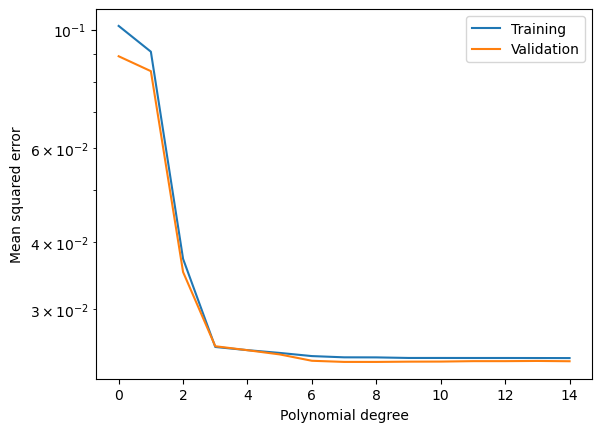

In [19]:
plt.semilogy(range(15), err_train[:15], range(15), err_cv[:15])
plt.legend(["Training", "Validation"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")

Looking at the plot, maybe a polynomial degree somewhere between six and eight looks like it has the lowest cross validation error.  Though it would also be reasonable, I think, to advocate for a polynomial of degree three, as the loss sharpely decreases up until this point, and then only improves to a minor degree afterwards, so we may want to prefer the simplicity of the degree three polynomial.


#### Train-test split with `scikit learn`

We can also make our life easier and use the `train_test_split` in `scikit learn`.

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
# split the data with 70%-30% split as above
x_train, x_test, y_train, y_test = train_test_split(df["High_temp"], df["MAX"], test_size=0.3,random_state=42)

This gives us a very similar random test split (see figure below).

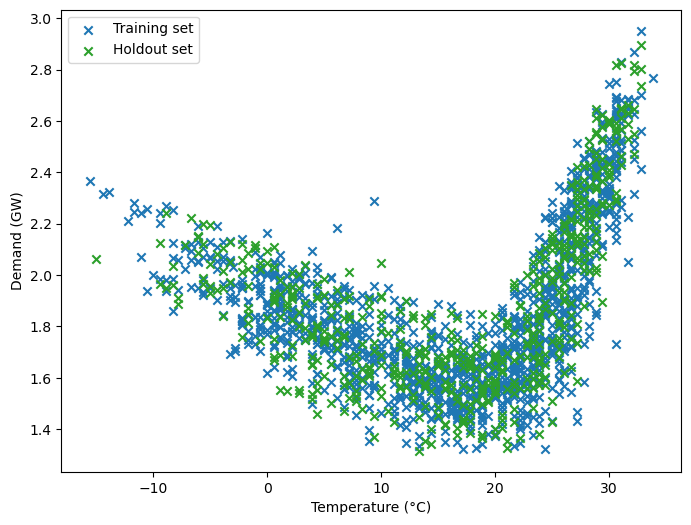

In [22]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_test, marker='x', color="C2")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Holdout set'])
plt.show()
#plt.savefig('crossvalidation.pdf', dpi = 300)

Remember: the correct procedure is to train your model on one set and evaluate it on the other.

In [23]:
# fit the model on one set of data
poly_reg = PolynomialFeatures(degree = 6)
x_poly = poly_reg.fit_transform(x_train.values.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly, y_train)

# evaluate the model on the second set of data
y_pred = model.predict(poly_reg.fit_transform(x_test.values.reshape(-1,1)))
print('The R^2 for quadratic curve is: ',r2_score(y_test, y_pred))


The R^2 for quadratic curve is:  0.7683356592022715


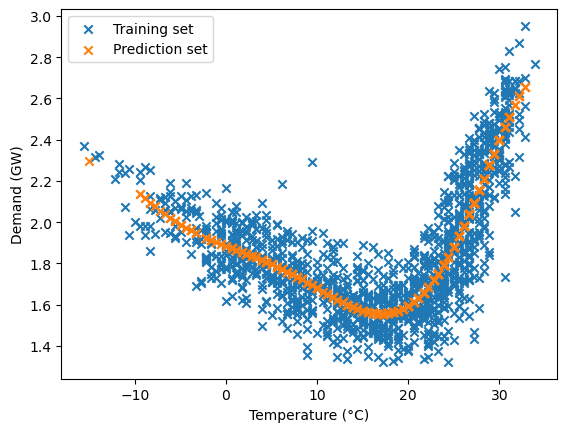

In [24]:
plt.scatter(x_train, y_train, marker='x', color="C0")
plt.scatter(x_test, y_pred, marker='x', color="C1")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (GW)")
plt.legend(['Training set', 'Prediction set'])

### Cross validation using train/holdout/test splits

As we have discussed in last week's lecture, it is advisable to actually do a three-ways split of the dataset to avoid leakage. You would typically do the following:

1. Divide data into training
set, holdout set, and test
set
2. Train algorithm on training
set (i.e., to learn
parameters), use holdout
set to select
hyperparameters
3. (Optional) retrain model
on training + holdout
4. Evaluate performance on
test set

In [25]:
# do a 70-30 split first
X_train, X_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=34)

# now split X_train to achive 50-20-30 split
X_train, X_hold, y_train, y_hold = train_test_split(X_train, y_train, test_size=(0.2/0.7),random_state=34)

In [26]:
print(len(X_train),len(X_hold),len(X_test))

912 365 548


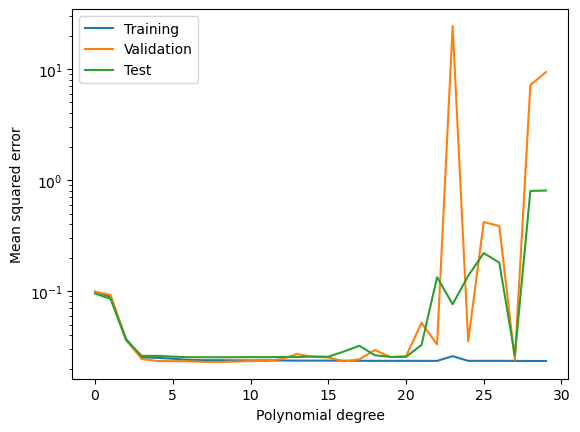

In [27]:
# again we can plot the errors to compare
min_x_train, max_x_train = X_train.min(), X_train.max()
x_train = 2*(X_train - min_x_train)/(max_x_train - min_x_train) - 1
x_hold = 2*(X_hold - min_x_train)/(max_x_train - min_x_train) - 1
x_test = 2*(X_test - min_x_train)/(max_x_train - min_x_train) - 1

def poly_feat(x, degree):
    return np.array([x**i for i in range(degree,-1,-1)]).T
    
err_train = []
err_hold = []
err_test = []
for i in range(30):
    theta = ls_poly(x_train, y_train, i)
    err_train.append(((poly_feat(x_train,i) @ theta - y_train)**2).mean())
    err_hold.append(((poly_feat(x_hold,i) @ theta - y_hold)**2).mean())
    err_test.append(((poly_feat(x_test,i) @ theta - y_test)**2).mean())
plt.semilogy(range(30), err_train, range(30), err_hold,range(30), err_test)
plt.legend(["Training", "Validation", "Test"])
plt.xlabel("Polynomial degree")
plt.ylabel("Mean squared error")
plt.show()

---

## Regularization

We have so far seen that the degree of the polynomial we use for our nonlinear features acts as a nice characterization of the model complexity.  But there is another notion of model complexity that is also important to understand, the _magnitude_ of the model parameters.  To see why this is important, let's look again at our degree 100 polynomial fit to the data above. Let's also look at the actual weights involved with this fit.

[ -416446.58345106  1678986.27406802  -613206.60569437   845062.5420469
   -55497.84705352 -1516712.81546627   740868.90757933]


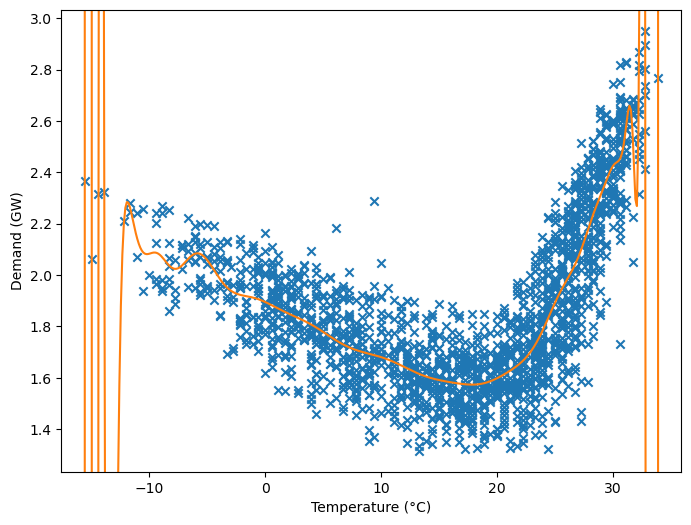

In [28]:
plot_regression_poly(x = xp, y = yp, d = 100)

The way that we get the polynomial to exactly pass through the points requires extremely high values for the coefficients: we need to set the coefficients just so that the different polynomial terms largely “cancel” out precisely at the data points and fit the function exactly to the data.

This also suggests another method for controlling the complexity of the model class: 
restricting the magnitude of the coefficients. This is the basis of the technique known as regularization.

Formally, regularization is often written as an additional term in the canonical machine learning problem.  Instead of simply minimizing the average loss, we minimize the average loss plus a term that penalizes the magnitude of the coefficients (usually some function of a norm of the weights, often just the sum of squared weights also called $\ell_2$ regularization, but other functions are possible as well).  For example, let's consider the following optimization problem:
\begin{equation}
\underset{\theta}{minimize} \; \frac{1}{m}\sum_{i=1}^m \ell \left(h_\theta(x^{(i)}),y^{(i)} \right) + \lambda \sum_{i=1}^n \theta_i^2
\end{equation}
where $\lambda \in \mathbb{R}_+$ is what is called a _regularization parameter_.  $\lambda$ effectively trades off between minimizing the training loss (which naturally "wants" to use large weights), and keeping the weights small.  If $\lambda = 0$, we ignore the regularization term entirely, and just minimize training loss; but as $\lambda \rightarrow \infty$, the _only_ relevant term in the optimization problem becomes the sum of the squared weights, which is clearly minimized if we just pick $\theta = 0$.  Thus, by varying $\lambda$ between zero and some very large constant, we can "sweep out" different ranges of model complexity.

### Visualizing regularization
Let's see what this looks like on our 100 degree polynomial.  The figure above shows the situation with no regularization, i.e, $\lambda = 0$.  If we instead choose $\lambda = 1$, we get the following figure.

In [29]:
# x is the input variable
# y is the output variable
# d is the degree of polynomial regression
# lam is lambda, the degree of regularization

def plot_regularized_polyregression (x, y, lam, d):
    
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    X = np.array([xs**i for i in range(d,-1,-1)]).T
    theta = np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)  # see lecture notes for derivation!, where np.eye() returns the identity matrix
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt = 2*(xt0 - min_x)/(max_x - min_x) - 1
    Xt = np.array([xt**i for i in range(d,-1,-1)]).T
    yt = Xt @ theta
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, yt, 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)
    print(theta[:4])

[ 0.00578142 -0.02356882  0.00562394 -0.02254179]


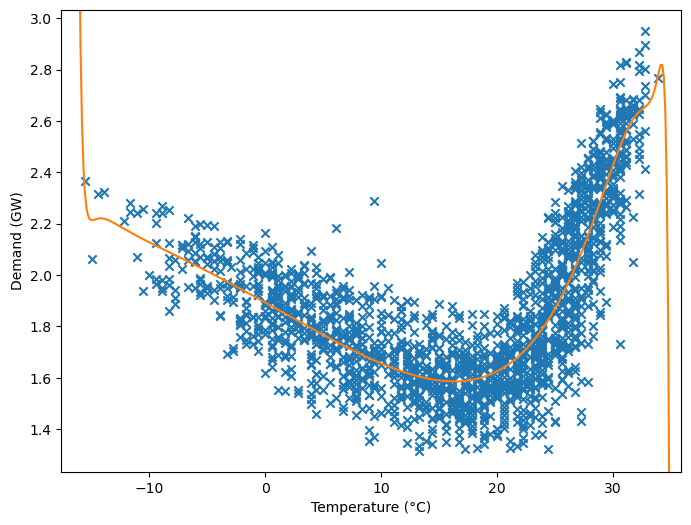

In [30]:
plot_regularized_polyregression (xp, yp, lam=1, d=100)

What happens if we regularize further? As we increase the value of lambda, the underlying function looks generally smoother (again, focusing mainly on the data between the extreme points).

[-0.00128759 -0.00283355 -0.00129545 -0.0028345 ]


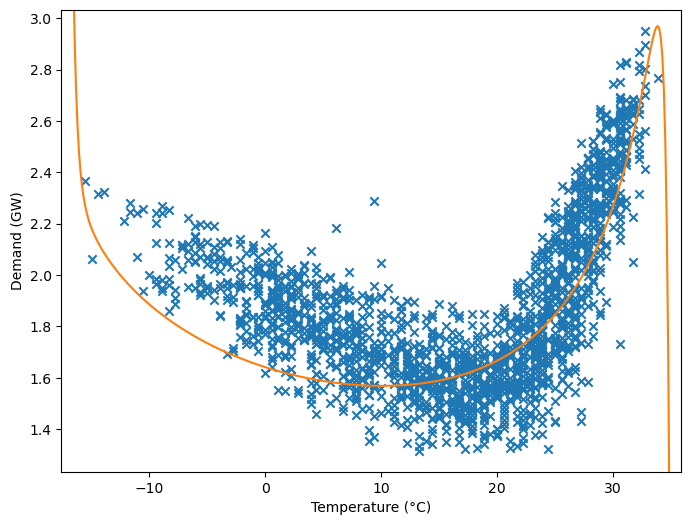

In [31]:
plot_regularized_polyregression (xp, yp, lam=100, d=100)

We can also understand what is happening here by reference to the previous section when we discussed polynomial fittings as a function of the degree of the polynomial.  Remember that after degree 10 or so, there wasn't a huge benefit of including additional polynomial terms in the regression.  Yet, if we include these terms within the context of a traditional least squares fit, we have seen that in order to use the polynomial degree to minimize the error (essentially done by "exactly" passing through some of the points), this is accomplished by a very high weight on the high-order coefficients.

So what happens when we apply a regularization penalty?  Because we know that we can achieve low error with a lower-degree polynomial, if we add sufficient regularization to the optimization objective, this will have the effect of avoiding putting much weight on the high-order terms in the polynomial, and just putting the weight on the lower order terms.  We can verify this by looking at the magnitude of the actual coefficients of $\theta$ before and after regularization (remember, $\theta$ is ordered in higher-to-lower degree polynomial terms, so we will flip the order to correspond to increasing degree of the polynomial terms).

In [32]:
def ls_poly_reg(x, y, lam, degree):
    xs = 2*(x - min(x))/(max(x) - min(x)) - 1   # rescale to range [-1,1]
    X = np.array([xs**i for i in range(degree,-1,-1)]).T
    return np.linalg.solve(X.T @ X + lam*np.eye(X.shape[1]), X.T @ y)

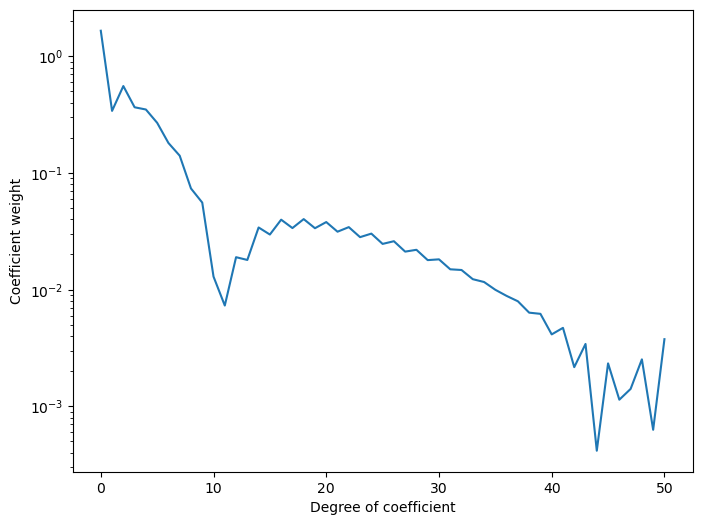

In [33]:
# define inputs
x=xp
y=yp
lam= 10
degree= 50

# plot function
theta = ls_poly_reg(x, y, lam, degree)

plt.figure(figsize = (8,6))
plt.semilogy(range(degree+1), np.abs(theta[::-1])) # reverse order of theta
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight")
plt.show()

### Regularization using `scikit learn`

#### Ridge regression ($L_2$ Regularization)

Perhaps the most common form of regularization is known as ridge regression or $L_2$ regularization. This is the process we have implemented manually above. It proceeds by penalizing the sum of squares (L2-norm) of the model coefficients; in this case, the penalty on the model fit would be $P = \alpha\sum_{n=1}^N \theta_n^2$ where $\alpha$ is a free parameter that controls the strength of the penalty (note that this is equivalent to our $\lambda$ from above). This type of penalized model is built into Scikit-Learn with the Ridge estimator. Remember: we first create polynomial features using the `PolynomialFeatures` module in `scikit learn`. Second, we standardize the input data, which you should always do when using Ridge (or Lasso) regression.

In [34]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# polynomial features
Poly = PolynomialFeatures(degree = 50, include_bias=False)
X_poly = Poly.fit_transform(xp.values.reshape(-1,1))

# scale input features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# initialize model
model_L2 = Ridge(alpha = 0.05, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(X_poly_scaled, yp)

# predict
prediction = model_L2.predict(X_poly_scaled)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )
print ('The R^2 for quadratic curve is: ',r2_score(yp, prediction))

The R^2 for quadratic curve is:  0.7533830058687765


In [35]:
# function for plotting

def plot_scikit_output(x, y, fitted_model):
    
    # create, normalize and generate polynomial features to plot predictions
    min_x, max_x = x.min(), x.max()
    xt0 = np.linspace(min_x-1, max_x+1, 400)
    xt0_poly = Poly.fit_transform(xt0.reshape(-1,1))
    xt0_poly_scaled = scaler.transform(xt0_poly)
    
    # plotting routine
    plt.figure(figsize = (8,6))
    plt.scatter(x, y, marker="x")
    ylim = plt.ylim()
    plt.plot(xt0, fitted_model.predict(xt0_poly_scaled), 'C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (GW)")
    plt.xlim([min_x-2, max_x+2])
    plt.ylim(ylim)

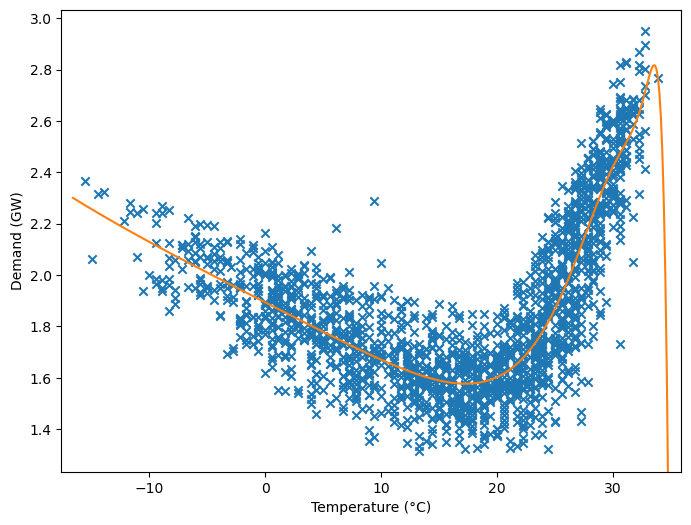

In [36]:
plot_scikit_output(xp, yp, model_L2)

#### LASSO regression ($L_1$ regularization)

Another very common type of regularization is known as lasso, and involves penalizing the sum of absolute values (1-norms) of regression coefficients: 
$$P = \alpha\sum_{n=1}^N |\theta_n|$$
Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible: that is, it preferentially sets model coefficients to exactly zero. As a result, Lasso can be readily used as an embedded method for feature selection.

In [ ]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.01, max_iter=10000)

model_L1.fit(X_poly_scaled, yp)

predict = model_L1.predict(X_poly_scaled)

#print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )
print ('The R^2 for quadratic curve is: ',r2_score(yp, predict))

The R^2 for quadratic curve is:  0.7262786245214051


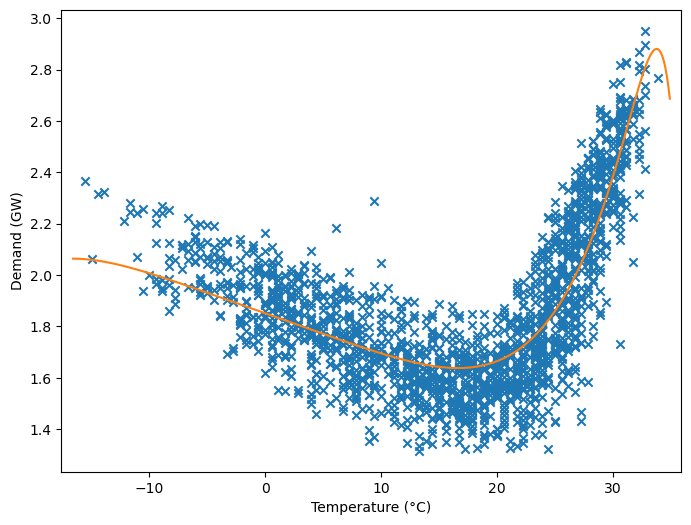

In [38]:
plot_scikit_output (xp, yp, model_L1)

### Regularization and cross-validation performance

We can also illustrate the effects of regularization as they relate to training and validation performance.  Just as we did with the degree of the polynomial, we can consider the training and validation errors for different amounts of regularization.

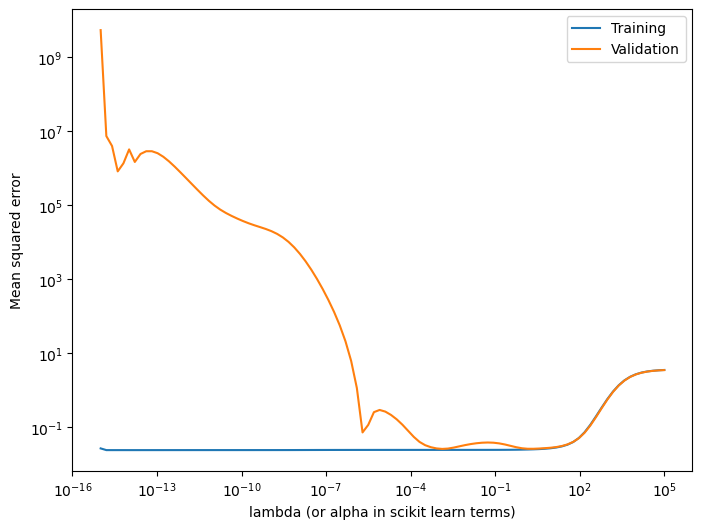

In [39]:
Grid_Search_Range = np.logspace(-15, 5, 100)
def plot_L2_regression_performance (x, y, deg):
    # Errors for Training and Testset
    err_train = []
    err_cv = []
    # Scale input vectors to [-1,1]
    min_x, max_x = x.min(), x.max()
    xs = 2*(x - min_x)/(max_x - min_x) - 1
    #Train-Test-Split
    x_train, x_test, y_train, y_test = train_test_split(xs, y, test_size=0.3, random_state = 10)
    #Polynomials
    X_train_scaled_poly = np.array([x_train**i for i in range(deg,-1,-1)]).T
    X_test_scaled_poly = np.array([x_test**i for i in range(deg,-1,-1)]).T
    for alpha in Grid_Search_Range:
        # Fit coefficients on Test Set
        theta_ridge = np.linalg.solve(X_train_scaled_poly.T @ X_train_scaled_poly + alpha*np.eye(X_train_scaled_poly.shape[1]), X_train_scaled_poly.T @ y_train)
        # Compute Predictions
        y_hat_train = X_train_scaled_poly @ theta_ridge
        y_hat_test = X_test_scaled_poly @ theta_ridge
        # compute errors
        err_train.append(mean_squared_error(y_train, y_hat_train))
        err_cv.append(mean_squared_error(y_test, y_hat_test))
    plt.figure(figsize = (8,6))
    plt.loglog(Grid_Search_Range, err_train,
               Grid_Search_Range, err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("lambda (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    #plt.xlim(10**(-4))
    #plt.ylim(0.01, 10)
    plt.show()
plot_L2_regression_performance(xp, yp, 100)

A few points are worth emphasizing here.  First, the nature of the regularization term: lower $\lambda$ means _less_ regularization, whereas larger $\lambda$ correspond to more regularization (eventually just essentially corresponding to all zero weights).  Thus, larger $\lambda$ means _lower_ model complexity, so the x-axis of the figure above works in the opposite direction as in the polynomial degree example.  Second, also note that we are using a _logarithmic_ scale on the x-axis (and the y-axis, as before, but the x-axis is the important part here).  This means that regularization typically works on a scale of _orders of magnitude_.  If you search over possible regularization terms, you'll want to do this search over a logarithmic space, because you need very large changes to the magnitude of $\lambda$ to really illustrate the full differences.  Third and last, just as was the case for the polynomial degree, we emphasize that the cross validation error is not a nice unimodal function of $\lambda$; there are multiple local optima owing to the pecularities of the particular polynomial, and it is not easy to globally optimize $\lambda$ by looking at cross validation error in some local region alone.  For this reason, techniques like grid searches are often more common in practice for finding model hyperparameters (including the $\lambda$ term), instead of techniques like gradient-based optimization.

This plot suggests that regularization parameters between $10^{-2}$ and $10^1$ appear to work best for this problem (I would personally not put much stock in the middle bump between the two extremes, as this is likely an artificat of the particular cross validation set, and the whole range still suffers relatively low error.

---

## Some other regression algorithms in scikit-learn

So far we have only talked about parameterized regression algorithms, i.e. algorithms that make relatively strong assumptions about the functional relationship between features and dependent variable (i.e. the target). We will shortly introduce some other regression modelling techniques, just to give you glimpse of the range of other procedures that exist.

### `KNN regression`

Regression based on k-nearest neighbors. The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.

Out of all the machine learning algorithms, KNN is easily the simplest to pick up. Despite it’s simplicity, it has proven to be effective at certain tasks. KNN can be used for both classification and regression problems. Although it is far more popular for classification problems it can perform well in regression tasks as well. One of the benefits of KNN is that it is an **unparametric** algorithm, i.e it does not make strong assumptions about the form of the mapping function. By not making assumptions, KNN is free to learn any functional form from the training data. 

In [40]:
x_train, x_test, y_train, y_test = train_test_split(xp, yp, test_size=0.3,random_state=10)

In [41]:
from sklearn.neighbors import KNeighborsRegressor

# initialize
KNN_reg = KNeighborsRegressor(n_neighbors=25) # specify the number of neighbors you want to use

# train
KNN_model = KNN_reg.fit(x_train.values.reshape(-1,1), y_train) 

# predict
y_hat_KNN = KNN_model.predict(x_test.values.reshape(-1,1))

In [42]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_test, y_hat_KNN), "GW")
print("RMSE:",(mean_squared_error(y_test, y_hat_KNN))**(0.5), "GW")  
print("R2:",r2_score(y_test, y_hat_KNN))

Test set performance:
MAE: 0.12792355963503652 GW
RMSE: 0.15934961010047832 GW
R2: 0.755151945391896


Let us visualize the results...

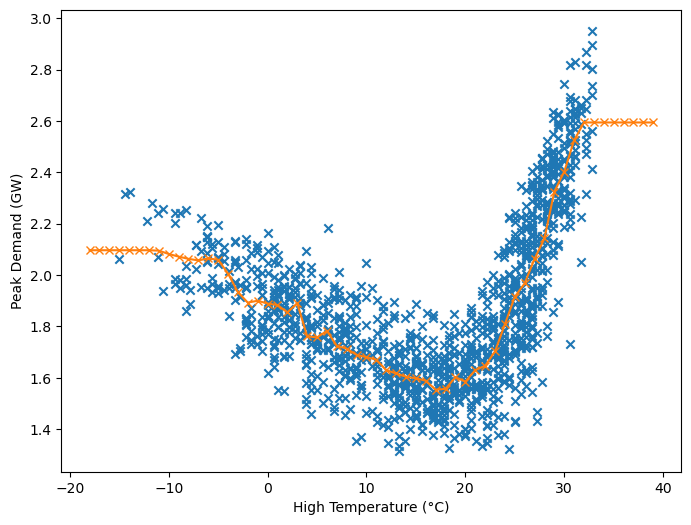

In [43]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), KNN_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

What is a good choice of the number of neighbors `n_neighbors`, the key hyperparameter in KNN regression? Let's write a small loop to test different values for `n_neighbors` (i.e., perform a grid search over different choices for `n_neighbors`).

In [44]:
def find_knn(x,y,max_k):
    
    err_train = [] 
    err_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)

    for n in np.arange(1,max_k):

        # initialize and fit model
        KNN_reg = KNeighborsRegressor(n_neighbors=n)
        KNN_model = KNN_reg.fit(x_train.values.reshape((-1,1)), y_train)


        # compute errors
        err_train.append(mean_absolute_error(KNN_model.predict(x_train.values.reshape((-1,1))), y_train))
        err_test.append(mean_absolute_error(KNN_model.predict(x_test.values.reshape((-1,1))), y_test))
        
    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,max_k), err_train, np.arange(1,max_k), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Number of neighbors")
    plt.ylabel("MAE")
    plt.show()


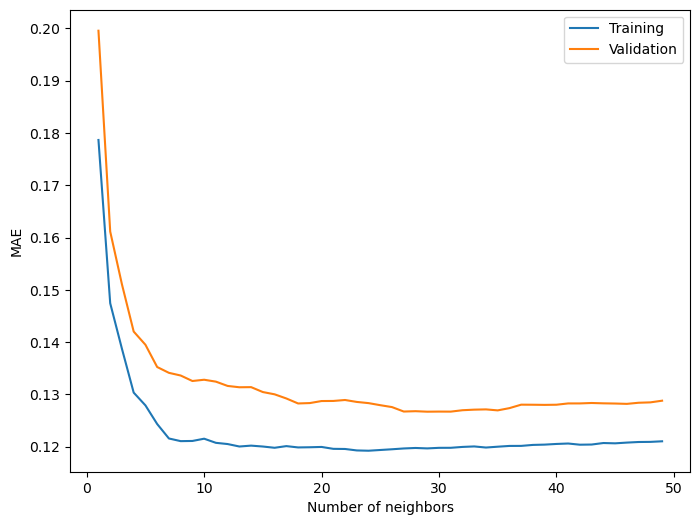

In [45]:
find_knn(xp,yp,max_k=50)

### `Tree-based regression`

Decision tree regression models are easy to understand and to use. Predictions are made by traversing the tree until reaching a terminal node. The predicted value is the average target value of training observations in the respective terminal node.

In [46]:
# import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor

# initialize
Tree_reg = DecisionTreeRegressor(max_depth=3)

# train
tree_model = Tree_reg.fit(x_train.values.reshape((-1,1)), y_train) 

# predict
y_hat_tree = tree_model.predict(x_test.values.reshape((-1,1)))

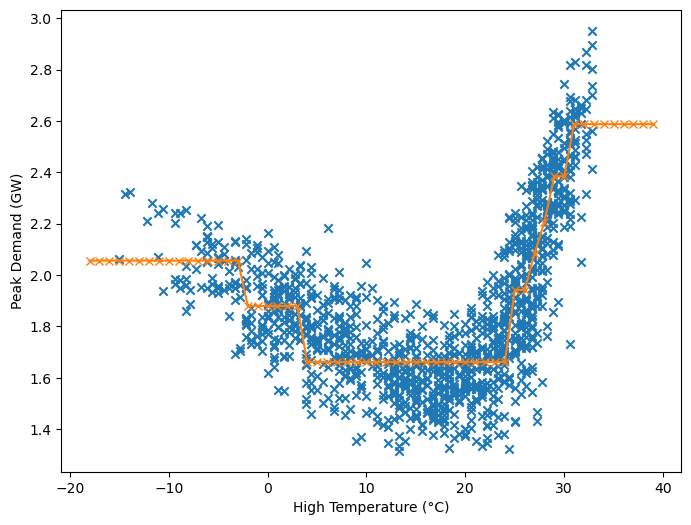

In [47]:
plt.figure(figsize = (8,6))
plt.scatter(x_train, y_train, marker="x")
plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
plt.xlabel("High Temperature (°C)")
plt.ylabel("Peak Demand (GW)")
plt.show()

In [48]:
from sklearn.tree import export_text

tree_rules = export_text(tree_model)
print(tree_rules)

|--- feature_0 <= 26.95
|   |--- feature_0 <= 3.60
|   |   |--- feature_0 <= -2.90
|   |   |   |--- value: [2.06]
|   |   |--- feature_0 >  -2.90
|   |   |   |--- value: [1.88]
|   |--- feature_0 >  3.60
|   |   |--- feature_0 <= 24.15
|   |   |   |--- value: [1.66]
|   |   |--- feature_0 >  24.15
|   |   |   |--- value: [1.94]
|--- feature_0 >  26.95
|   |--- feature_0 <= 28.60
|   |   |--- feature_0 <= 27.50
|   |   |   |--- value: [2.08]
|   |   |--- feature_0 >  27.50
|   |   |   |--- value: [2.21]
|   |--- feature_0 >  28.60
|   |   |--- feature_0 <= 30.85
|   |   |   |--- value: [2.38]
|   |   |--- feature_0 >  30.85
|   |   |   |--- value: [2.59]



In [49]:
print("Test set performance:")

print("MAE:",mean_absolute_error(y_test, y_hat_tree), "GW")
print("RMSE:",(mean_squared_error(y_test, y_hat_tree))**(0.5), "GW")  
print("R2:",r2_score(y_test, y_hat_tree))

Test set performance:
MAE: 0.13365333631364112 GW
RMSE: 0.16878592410907545 GW
R2: 0.7252946616781333


What is a good choice of the tree depths `max_depth`, the key hyperparameter in tree regression? Let's write a small loop to test different values for `max_depth` and the respective error metrics.

In [50]:
def find_tree_depth (x,y,max_depth):
    
    # define list for collecting results
    err_train = [] 
    err_test = []
    
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=10)
    
    # loop over max_depth
    
    for n in np.arange(1,max_depth+1):
        
        # initialize and fit model
        tree_reg = DecisionTreeRegressor(max_depth=n)
        tree_model = tree_reg.fit(x_train.values.reshape(-1,1),y_train)
        
        # compute errors
        err_train.append(mean_absolute_error(y_train, tree_model.predict(x_train.values.reshape(-1,1))))
        err_test.append(mean_absolute_error(y_test, tree_model.predict(x_test.values.reshape(-1,1))))


    plt.figure(figsize = (8,6))
    plt.plot(np.arange(1,21), err_train, np.arange(1,21), err_test)
    plt.legend(["Training", "Validation"])
    plt.xlabel("Max Tree Depth")
    plt.ylabel("MAE")
    plt.title("Search over max_depth parameter",fontsize=14)
    plt.show()

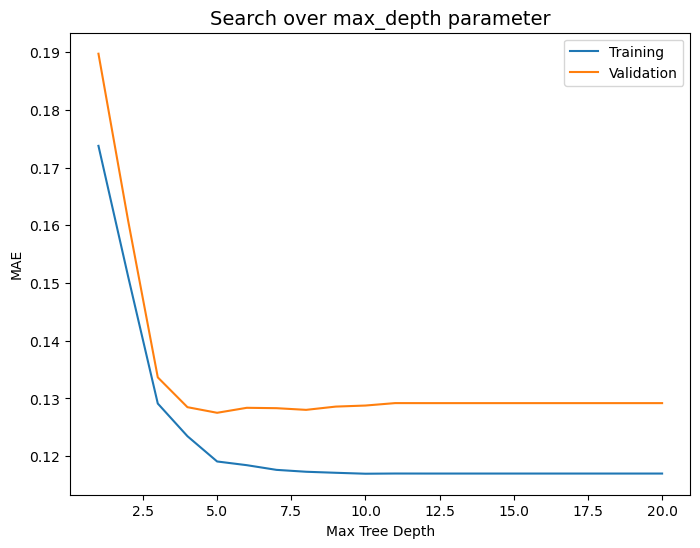

In [51]:
find_tree_depth (xp,yp,20)

The above exercises are what is commonly known as **grid searching an algorithm**. Grid searching is the practice of testing a large range of model hyperparameters via brute force. It is a key component of model selection and evaluation and should be carried out very thoroughly!

---